In [24]:
import os
import time
import random
import collections

import gym
from gym import wrappers
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
from td3 import TD3

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

def live_plot(data_dict, figsize=(15,5)):

    clear_output(wait=True)
    plt.figure(figsize=figsize)
    
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    
    plt.legend(loc='lower left')
    plt.show();
    

In [4]:
def mkdir(base, name):

    path = os.path.join(base, name)
  
    if not os.path.exists(path):
        os.makedirs(path)
  
    return path


---
---
---

##### Environment

In [5]:
env_name = 'LunarLanderContinuous-v2'
save_models = True
seed = 341

##### Initialize environment and set seeds

In [6]:
env = gym.make(env_name)

env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

##### Create folder in which trained models will be saved

In [8]:
if all([save_models, not os.path.exists('./pytorch_models')]):
    os.makedirs('./pytorch_models')
if all([save_models, not os.path.exists('./pytorch_models/all_td3')]):
    os.makedirs('./pytorch_models/all_td3')

In [9]:
file_name = f'TD3_{env_name}_{seed}'
print(file_name)

TD3_LunarLanderContinuous-v2_341


##### Initialize agent parameters

In [10]:
buffer_size = 1e6
batch_size = 100

gamma = 0.99
tau = 5e-3
policy_freq = 2
lr = 1e-3

policy_noise = 0.2
noise_clip = 0.5
expl_noise = 0.1

##### Initialize agent

In [11]:
agent = TD3(
    state_dim, 
    action_dim, 
    max_action,
    eta=lr,
)


---

##### Initialize training variables 

In [12]:
#agent.load(file_name, './pytorch_models')

In [13]:
starting_step = 1e4 # Number of random steps at start
max_steps = 1000 # Max steps per episode

episodes = 1500
total_steps = 0
training = False
report = 50

In [14]:
reward_trace = collections.defaultdict(list)

##### Training:

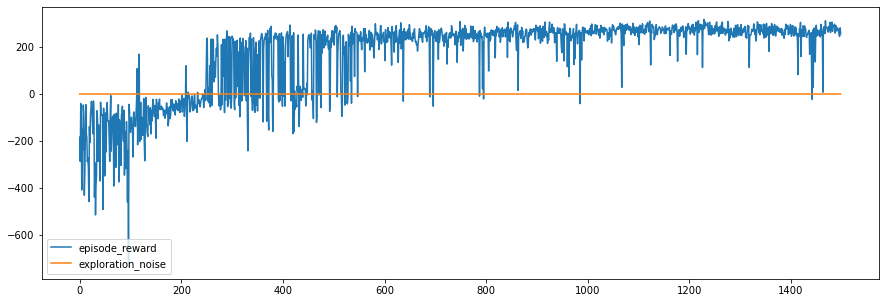

In [15]:
for episode in np.arange(1, episodes):             
    
    obs = env.reset()
    done = False
    episode_reward = []
    steps = 0
    
    
    
    while not done:        
        
        if total_steps == starting_step:
            print('Begin training')
            training = True
            
        if not training:
            action = env.action_space.sample()
        else:
            action = agent.select_action(np.array(obs))
            
            if expl_noise != 0:
                noise = np.random.normal(0, expl_noise, size=env.action_space.shape[0])
                action = (action+noise).clip(env.action_space.low, env.action_space.high)
                
        new_obs, reward, done, info = env.step(action)
        
        done = (done) or (steps >= max_steps)
        #reward *= 2 if steps >= max_steps else 1 ###

        episode_reward.append(reward)
        agent.replay_buffer.add((obs, new_obs, action, reward, int(done)))
        
        obs = new_obs
        steps += 1
        total_steps += 1


        
    agent.train(steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_freq)
    reward_trace['episode_reward'].append(sum(episode_reward))
    reward_trace['exploration_noise'].append(round(expl_noise, 9))
    live_plot(reward_trace)
 
    if (episode) % report == 0:
        
        print('Episode:', episode)
        print('Average score:', np.mean(reward_trace['episode_reward'][-report:]))
        print('Exploration noise:', reward_trace['exploration_noise'][-1])
        print('Training:', training)
        time.sleep(1)
        
        agent.save(
            f'{file_name}_{episode}', 
            './pytorch_models/all_td3',
        )
        

In [16]:
total_steps

604226

In [17]:
episode

1499

In [18]:
expl_noise

0.1

##### Plot reward trace

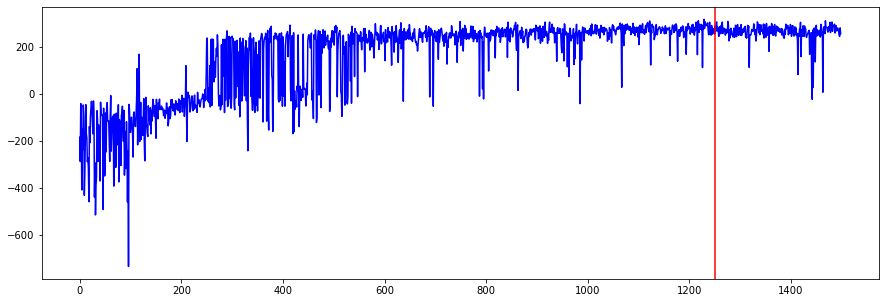

In [21]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['episode_reward'], 'b')
#plt.plot(reward_trace['episode_reward'][:10], 'r')
plt.axvline(1250, c='r')

plt.show()

##### Save only model from selected point in training history

In [22]:
idx = 1250

agent.load(
    f'{file_name}_{idx}', 
    './pytorch_models/all_td3',
)

agent.save(
    file_name, 
    './pytorch_models',
)

for item in os.listdir('./pytorch_models/all_td3'):
    os.remove(os.path.join('./pytorch_models/all_td3', item))

In [25]:
df = pd.read_csv('performance.csv')
df.shape

(1499, 1)

In [27]:
df['td3'] = reward_trace['episode_reward']
df.to_csv('performance.csv', index=False)